In [19]:
import os, sys, time
sys.path.append("../src")

from tqdm import tqdm
import numpy as np
import torch
import argparse
from datasets import load_from_disk
from transformers import ViTForImageClassification
from utils.helper import get_device
from utils.vit_util import transforms
from utils.constant import ViTExperiment
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("ticks")

In [39]:
def plot_proba_diff(ds_name, num_labels, save_dir, used_column):
    diff_enh_lst, diff_sup_lst = [], []
    for tgt_label in range(num_labels):
        ori_proba = np.load(os.path.join(save_dir, f"{used_column}_proba_{tgt_label}.npy"))[:, tgt_label]
        enh_proba = np.load(os.path.join(save_dir, f"{used_column}_proba_ig_list_l9tol12_enhance_{tgt_label}.npy"))[:, tgt_label]
        sup_proba = np.load(os.path.join(save_dir, f"{used_column}_proba_ig_list_l9tol12_suppress_{tgt_label}.npy"))[:, tgt_label]
        # 差分を計算
        diff_enh = enh_proba - ori_proba
        diff_sup = sup_proba - ori_proba
        diff_enh_lst.append(diff_enh)
        diff_sup_lst.append(diff_sup)
    diff_enh_lst = np.array(diff_enh_lst)
    diff_sup_lst = np.array(diff_sup_lst)
    print(f"avg. enh. prob. diff. = {diff_enh_lst.mean()*100}")
    print(f"avg. sup. prob. diff. = {diff_sup_lst.mean()*100}")
    # diff_enh_lstを1軸目方向に平均してプロット
    plt.figure(figsize=(8, 6))
    plt.plot(diff_enh_lst.mean(axis=1)*100, label="Enhance", color="red")
    plt.plot(diff_sup_lst.mean(axis=1)*100, label="Suppress", color="blue")
    plt.axhline(0, color="black", linestyle="--")
    plt.xlabel("Class Label")
    plt.ylabel("Average Change of Probability (%)")
    plt.legend()
    plt.show()

avg. enh. prob. diff. = 0.22300654090940952
avg. sup. prob. diff. = -5.844159051775932


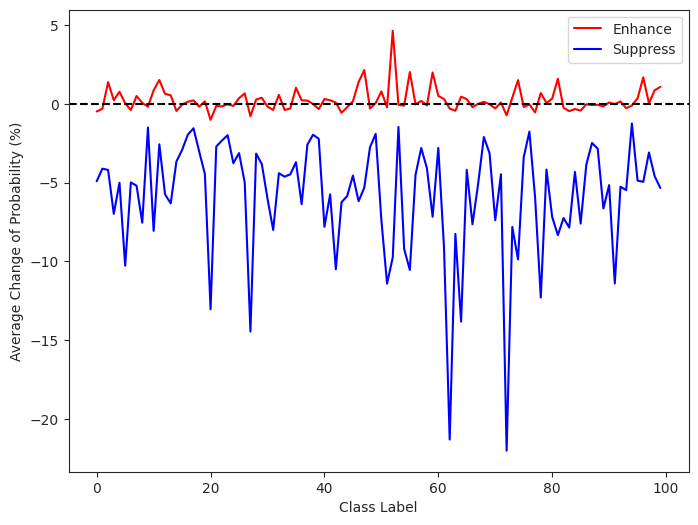

In [40]:
ds_name = "c100"
num_labels = 100
save_dir = os.path.join(getattr(ViTExperiment, ds_name).OUTPUT_DIR, "pred_results")
used_column = "train"
plot_proba_diff(ds_name, num_labels, save_dir, used_column)

avg. enh. prob. diff. = -0.03576369199436158
avg. sup. prob. diff. = -0.21748363506048918


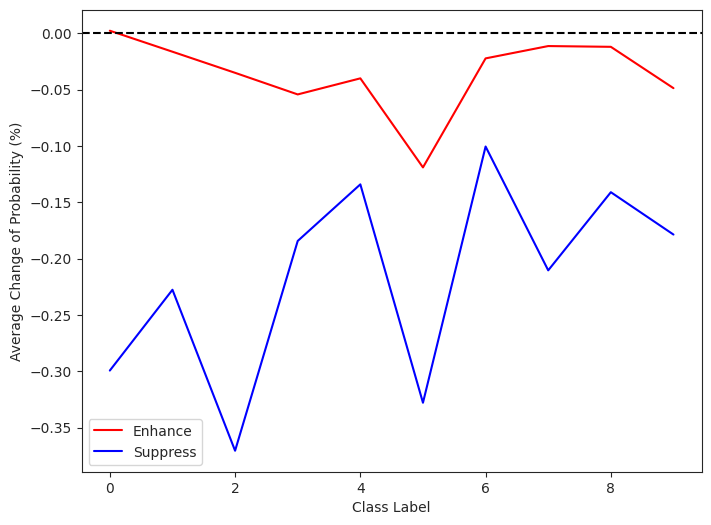

In [41]:
ds_name = "c10"
num_labels = 10
save_dir = os.path.join(getattr(ViTExperiment, ds_name).OUTPUT_DIR, "pred_results")
used_column = "train"
plot_proba_diff(ds_name, num_labels, save_dir, used_column)